In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.utils.validation import _check_large_sparse
from tslearn.clustering import TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

We are dealing with AU values only, using all_videos.csv that we had generated before.

We group the data by file name and face id (to seperate emotions as much as possible) and then split the big chunks of frames to smaller chunks of $50$ frames.

In [ ]:
X_df = pd.read_csv('./all_videos.csv', index_col=None)
# target_emotion = 'contempt'
# target_culture = 'North America'
# X_df = X_df[(X_df['emotion'] == target_emotion) & (X_df['culture'] == target_culture)]
print(X_df.head())
# filenames = X['filename'].unique()
# face_ids = X['face_id'].unique()
videos = X_df['filename'].unique()
test_videos = pd.Series(videos).sample(frac=0.20)
valid_videos = pd.Series(test_videos).sample(frac=0.50).values
train_videos = np.array(list(set(videos) - set(test_videos)))
test_videos = np.array(list(set(test_videos) - set(valid_videos)))


TODO: Also do without frame limit.

In [ ]:
grouped = X_df.groupby(by=['filename', 'face_id'])
## Separating test data
test_ts_list = list()
test_metadata = list()
# X_list is video/face frames, divided into 50 frames chunks
X_list = []
metadata = []
frame_limit = 50
for key in grouped.groups:
    X_group = grouped.get_group(key)
    # X_group = X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1)
    if len(X_group) >= frame_limit:
        splitted_group = np.array_split(X_group, math.ceil(len(X_group) / frame_limit))
        for g in splitted_group:
            X_list.append(g.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1).to_numpy())
            metadata.append({'filename': g.loc[g.index[0], 'filename'], 'emotion': g.loc[g.index[0], 'emotion'], 'face_id':g.loc[g.index[0], 'face_id']})
    else:
        X_list.append(X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1).to_numpy())
        metadata.append({'filename': X_group.loc[X_group.index[0], 'filename'], 'emotion': X_group.loc[X_group.index[0], 'emotion'], 'face_id':X_group.loc[X_group.index[0], 'face_id']})

X_list and Y_list are lists of 728 elements

1-th split
Training accuracy for k=2: 0.8815165876777251
Validation accuracy for k=2: 0.5
Training accuracy for k=3: 0.8436018957345972
Validation accuracy for k=3: 0.5
Training accuracy for k=4: 0.8056872037914692
Validation accuracy for k=4: 0.5
Training accuracy for k=5: 0.7630331753554502
Validation accuracy for k=5: 0.5833333333333334
Training accuracy for k=6: 0.7393364928909952
Validation accuracy for k=6: 0.5833333333333334
Training accuracy for k=7: 0.7251184834123223
Validation accuracy for k=7: 0.5
Training accuracy for k=8: 0.7014218009478673
Validation accuracy for k=8: 0.625
Training accuracy for k=9: 0.6682464454976303
Validation accuracy for k=9: 0.4583333333333333
Training accuracy for k=10: 0.6966824644549763
Validation accuracy for k=10: 0.5
Training accuracy for k=11: 0.6682464454976303
Validation accuracy for k=11: 0.5
Training accuracy for k=12: 0.6729857819905213
Validation accuracy for k=12: 0.5
Training accuracy for k=13: 0.6303317535545023
Validation accuracy 

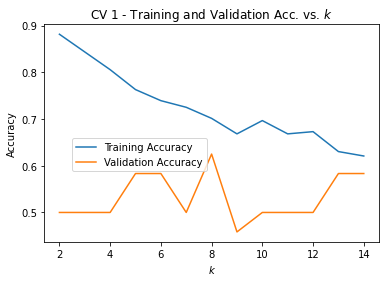

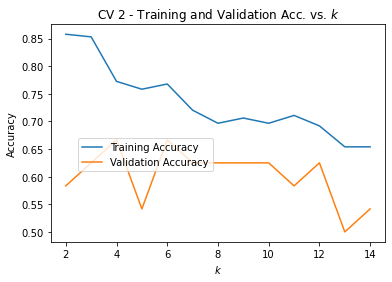

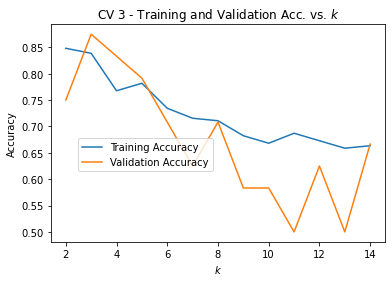

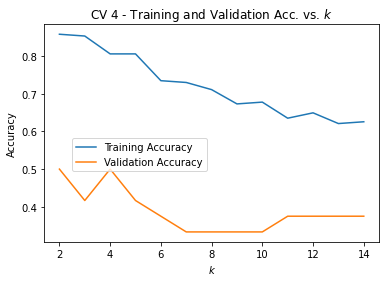

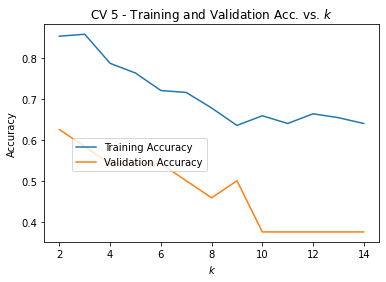

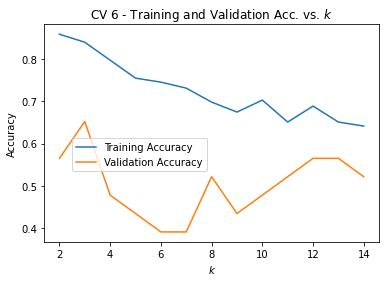

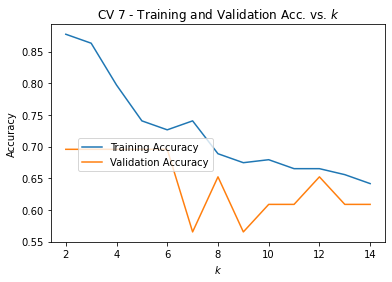

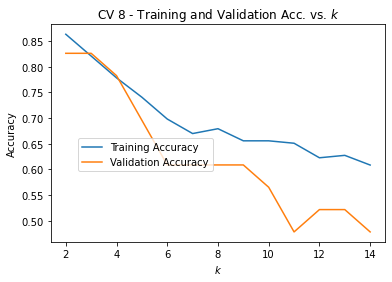

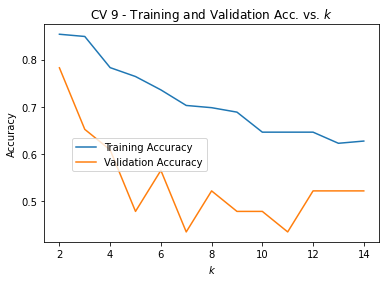

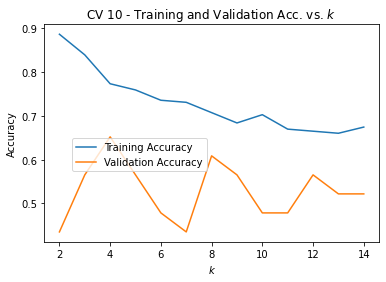

In [13]:
# TODO: fix copying y_list lines (two lines below:)
# metadata = y_list.copy()
y_list = [x['emotion'] for x in metadata]
# print(X_list[0].shape)
X_ts = to_time_series_dataset(X_list)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
splits = kf.split(videos)
for (i, (train_index, test_index)) in enumerate(splits):
    print('%d-th split' % (i+1))
    X_train, X_test = X_ts[train_index], X_ts[test_index]
    Y_train, Y_test = np.array(y_list)[train_index], np.array(y_list)[test_index]
    K_MAX = 15
    K_MIN = 2
    train_acc = []
    valid_acc = []
    for k in range(K_MIN, K_MAX):
        knn_classifier = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric='dtw')
        knn_classifier.fit(X_train, Y_train)
        train_predicted_labels = knn_classifier.predict(X_train)
        train_acc.append(accuracy_score(Y_train, train_predicted_labels))

        print("Training accuracy for k={}: {}".format(k, train_acc[-1]))
        val_predicted_labels = knn_classifier.predict(X_test)
        valid_acc.append( accuracy_score(Y_test, val_predicted_labels))
        print("Validation accuracy for k={}: {}".format(k, valid_acc[-1]))

    plt.plot(range(K_MIN, K_MAX), train_acc, label='Training Accuracy')
    plt.xlabel('$k$')
    plt.ylabel('Accuracy')
    # plt.show()

    plt.plot(range(K_MIN, K_MAX), valid_acc, label='Validation Accuracy')
    plt.title('CV %d - Training and Validation Acc. vs. $k$' % (i+1))
    plt.xlabel('$k$')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5))
    plt.show()


## Grid Search Cross-Validation

In [12]:
from sklearn.model_selection import GridSearchCV
knn2 = KNeighborsTimeSeriesClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 15)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_list, np.array(y_list))

/home/roya/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/roya/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/roya/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roya/miniconda3/lib/python3.8/site-packages/tslearn/neighbors/neighbors.py", line 478, in fit
    X = check_array(X,
  File "/home/roya/miniconda3/lib/python3

KeyboardInterrupt: 

In [10]:
knn_gscv.best_params_
knn_gscv.best_score_

NameError: name 'knn_gscv' is not defined